In [ ]:
# !pip install torch torchvision 

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AstroUNet(nn.Module):
    def __init__(self, exp_injection=True):
        super().__init__()
        self.exp_injection = exp_injection

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.LeakyReLU(0.2),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.LeakyReLU(0.2)
            )

        self.enc1 = conv_block(1, 32)
        self.enc2 = conv_block(32, 64)
        self.enc3 = conv_block(64, 128)
        self.enc4 = conv_block(128, 256)
        self.enc5 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.dec6 = conv_block(512 + 256 + (1 if exp_injection else 0), 256)
        self.dec7 = conv_block(256 + 128, 128)
        self.dec8 = conv_block(128 + 64, 64)
        self.dec9 = conv_block(64 + 32, 32)

        self.final = nn.Conv2d(32, 1, kernel_size=1)

    def center_crop(self, enc_feat, target):
        _, _, h, w = enc_feat.size()
        _, _, th, tw = target.size()
        dh, dw = h - th, w - tw
        cropped = enc_feat[:, :, dh//2:h - (dh - dh//2), dw//2:w - (dw - dw//2)]
        return cropped

    def forward(self, x, exp_time=None):
        e = None
        if self.exp_injection and exp_time is not None:
            e = torch.full_like(x[:, :1], exp_time)

        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        e5 = self.enc5(self.pool(e4))

        # Decoder with interpolation + safe crop
        d6 = F.interpolate(e5, scale_factor=2, mode='bilinear', align_corners=False)
        e4_c = self.center_crop(e4, d6)
        if self.exp_injection:
            e_crop = self.center_crop(e, d6)
            d6 = torch.cat([d6, e4_c, e_crop], dim=1)
        else:
            d6 = torch.cat([d6, e4_c], dim=1)
        d6 = self.dec6(d6)

        d7 = F.interpolate(d6, scale_factor=2, mode='bilinear', align_corners=False)
        e3_c = self.center_crop(e3, d7)
        d7 = torch.cat([d7, e3_c], dim=1)
        d7 = self.dec7(d7)

        d8 = F.interpolate(d7, scale_factor=2, mode='bilinear', align_corners=False)
        e2_c = self.center_crop(e2, d8)
        d8 = torch.cat([d8, e2_c], dim=1)
        d8 = self.dec8(d8)

        d9 = F.interpolate(d8, scale_factor=2, mode='bilinear', align_corners=False)
        e1_c = self.center_crop(e1, d9)
        d9 = torch.cat([d9, e1_c], dim=1)
        d9 = self.dec9(d9)

        return self.final(d9)


In [4]:
from astroquery.mast import Observations
import os

# Broader JWST filters to try
jwst_filters = ["F115W", "F200W", "F356W"]  # You can add F277W, F444W, etc.

# Output base folder
base_dir = "data"

for filt in jwst_filters:
    print(f"\n🔍 Searching JWST I2D data for filter: {filt}")
    output_dir = os.path.join(base_dir, filt)
    os.makedirs(output_dir, exist_ok=True)

    # # Step 1: Query observations using only basic constraints
    # obs_table = Observations.query_criteria(
    #     obs_collection="JWST",
    #     proposal_id=1171,
    #     dataproduct_type="image",
    #     filters=[filt],
    # )

    obs_id = "jw04147-o012_t001_nircam_clear-f115w"
    
    # Step 1: Query this specific obs_id
    obs_table = Observations.query_criteria(obs_id=obs_id)

    if len(obs_table) == 0:
        print(f"⚠️ No observations found for filter {filt}")
        continue

    print(f"✅ Found {len(obs_table)} observations for filter {filt}")

    # Step 2: Get product list
    products = Observations.get_product_list(obs_table)

    # Step 3: Filter for I2D FITS products (drizzled 2D images)
    i2d_products = Observations.filter_products(
        products,
        productSubGroupDescription="I2D",
        extension="fits"
    )

    if len(i2d_products) == 0:
        print(f"⚠️ No I2D products found for filter {filt}")
        continue

    print(f"✅ Found {len(i2d_products)} I2D FITS files")

    # Optional: limit to first few files for testing
    i2d_products = i2d_products[:3]

    # Step 4: Download
    manifest = Observations.download_products(i2d_products, download_dir=output_dir)
    print(f"📥 Downloaded {len(manifest)} files to {output_dir}")



🔍 Searching JWST I2D data for filter: F115W
✅ Found 1 observations for filter F115W
✅ Found 49 I2D FITS files
📥 Downloaded 3 files to data/F115W

🔍 Searching JWST I2D data for filter: F200W
✅ Found 1 observations for filter F200W
✅ Found 49 I2D FITS files
📥 Downloaded 3 files to data/F200W

🔍 Searching JWST I2D data for filter: F356W
✅ Found 1 observations for filter F356W
✅ Found 49 I2D FITS files
📥 Downloaded 3 files to data/F356W


In [7]:
import torch
from torch.utils.data import Dataset
import os

class JWSTAstroDataset(Dataset):
    def __init__(self, txt_file, root_dir="./astronet_training/", transform=None):
        """
        Args:
            txt_file (str): Path to .txt file with image pair names (noisy and clean).
            root_dir (str): Directory with .pt files.
            transform (callable, optional): Optional transform to be applied.
        """
        with open(txt_file, 'r') as f:
            self.file_list = [line.strip() for line in f.readlines()]
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        noisy_file, clean_file = self.file_list[idx].split()
        noisy = torch.load(os.path.join(self.root_dir, noisy_file))
        clean = torch.load(os.path.join(self.root_dir, clean_file))
        if self.transform:
            noisy = self.transform(noisy)
            clean = self.transform(clean)
        return noisy, clean


In [8]:
from astropy.io import fits
import numpy as np

def load_jwst_i2d_image(fits_path):
    with fits.open(fits_path) as hdul:
        image = hdul['SCI'].data  # 2D science image
        header = hdul['SCI'].header
        image = np.nan_to_num(image)
        
        # Normalize (1%–99% clipping)
        vmin, vmax = np.percentile(image, [1, 99])
        norm_image = np.clip((image - vmin) / (vmax - vmin), 0, 1).astype(np.float32)
        
        # Exposure time
        exp_time = header.get("EXPTIME", 1000.0)
        
    return norm_image, exp_time


In [9]:
def simulate_noise(image, exp_time, ratio=2, ron=3, dark_current=7):
    """
    image: normalized [0, 1], assume units = e-/sec
    exp_time: in seconds
    """
    img_e = image * exp_time  # Convert to electrons

    signal = np.random.poisson(img_e / ratio)
    read_noise = np.random.normal(0, ron, image.shape)
    dark_noise = np.random.normal(0, np.sqrt(dark_current * exp_time / (3600 * ratio)), image.shape)

    noisy_e = signal + read_noise + dark_noise
    noisy_image = noisy_e / (exp_time / ratio)

    noisy_image = np.clip(noisy_image, 0, None)
    return noisy_image.astype(np.float32)


In [10]:
def extract_patches(image, patch_size=256, stride=256, max_patches=100):
    patches = []
    H, W = image.shape
    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            patch = image[i:i+patch_size, j:j+patch_size]
            if np.mean(patch) > 0.01:  # Skip blank
                patches.append(patch)
            if len(patches) >= max_patches:
                return patches
    return patches


In [11]:
import torch

def generate_training_pairs(image, exp_time, save_dir="./astronet_training/", prefix="jwst"):
    os.makedirs(save_dir, exist_ok=True)
    clean_patches = extract_patches(image)
    
    for idx, clean in enumerate(clean_patches):
        noisy = simulate_noise(clean, exp_time)
        
        clean_tensor = torch.from_numpy(clean).unsqueeze(0)  # [1, H, W]
        noisy_tensor = torch.from_numpy(noisy).unsqueeze(0)
        
        # Save as .pt files
        torch.save(noisy_tensor, os.path.join(save_dir, f"{prefix}_noisy_{idx:03d}.pt"))
        torch.save(clean_tensor, os.path.join(save_dir, f"{prefix}_clean_{idx:03d}.pt"))


In [12]:
import os
import random

def create_dataset_splits(save_dir="./astronet_training/", train_ratio=0.8, val_ratio=0.1):
    # Find all clean and noisy .pt files
    clean_files = sorted([f for f in os.listdir(save_dir) if "clean" in f and f.endswith(".pt")])
    noisy_files = sorted([f.replace("clean", "noisy") for f in clean_files])

    paired_files = list(zip(noisy_files, clean_files))
    random.shuffle(paired_files)

    total = len(paired_files)
    train_end = int(train_ratio * total)
    val_end = int((train_ratio + val_ratio) * total)

    splits = {
        "train.txt": paired_files[:train_end],
        "val.txt": paired_files[train_end:val_end],
        "test.txt": paired_files[val_end:]
    }

    for name, split in splits.items():
        with open(os.path.join(save_dir, name), "w") as f:
            for noisy, clean in split:
                f.write(f"{noisy} {clean}\n")
        print(f"✅ Saved {name} with {len(split)} pairs")

# Example usage:
create_dataset_splits()


✅ Saved train.txt with 51 pairs
✅ Saved val.txt with 6 pairs
✅ Saved test.txt with 7 pairs


In [10]:
# Step-by-step usage
fits_path = "data/F115W/mastDownload/JWST/jw04147012001_08101_00001_nrcb1/jw04147012001_08101_00001_nrcb1_i2d.fits"
image, exp_time = load_jwst_i2d_image(fits_path)
generate_training_pairs(image, exp_time)

In [17]:
from torch.utils.data import DataLoader

# # Define datasets
# train_set = JWSTAstroDataset(txt_file="./astronet_training/train.txt")
# val_set = JWSTAstroDataset(txt_file="./astronet_training/val.txt")
# test_set = JWSTAstroDataset(txt_file="./astronet_training/test.txt")

# # Dataloaders
# train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
# val_loader = DataLoader(val_set, batch_size=4, shuffle=False)
# test_loader = DataLoader(test_set, batch_size=4, shuffle=False)


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
# from astrounet_dataset import JWSTAstroDataset  # from previous step
# from astrounet_model import AstroUNet          # your converted U-Net model
import numpy as np

# === Hyperparameters ===
BATCH_SIZE = 8
NUM_EPOCHS = 100
LEARNING_RATE = 1e-4
SAVE_DIR = "./checkpoints_astrounet/"
os.makedirs(SAVE_DIR, exist_ok=True)

# === Data ===
train_dataset = JWSTAstroDataset("astronet_training/train.txt")
val_dataset = JWSTAstroDataset("astronet_training/val.txt")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# === Model, Loss, Optimizer ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AstroUNet(exp_injection=True).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

best_val_psnr = 0.0

# === Training Loop ===
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for noisy, clean in train_loader:
        noisy, clean = noisy.to(device), clean.to(device)
        exp_val = torch.tensor(2.0).to(device)  # inject exposure ratio (can vary)
        output = model(noisy, exp_val)

        loss = criterion(output, clean)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {avg_loss:.4f}")

    # === Evaluation ===
    model.eval()
    psnr_vals = []
    ssim_vals = []
    with torch.no_grad():
        for noisy, clean in val_loader:
            noisy, clean = noisy.to(device), clean.to(device)
            output = model(noisy, exp_val)
            output_np = output.cpu().squeeze().numpy()
            clean_np = clean.cpu().squeeze().numpy()

            psnr_vals.append(psnr(clean_np, output_np, data_range=1.0))
            ssim_vals.append(ssim(clean_np, output_np, data_range=1.0))

    avg_psnr = np.mean(psnr_vals)
    avg_ssim = np.mean(ssim_vals)
    print(f"   🔍 Val PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.3f}")

    # === Save best model ===
    if avg_psnr > best_val_psnr:
        best_val_psnr = avg_psnr
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, "best_model.pth"))
        print("   ✅ Saved new best model!")

Epoch 1/100, Train Loss: 0.2079
   🔍 Val PSNR: 13.60, SSIM: 0.221
   ✅ Saved new best model!
Epoch 2/100, Train Loss: 0.1456
   🔍 Val PSNR: 17.62, SSIM: 0.269
   ✅ Saved new best model!
Epoch 3/100, Train Loss: 0.0824
   🔍 Val PSNR: 19.57, SSIM: 0.287
   ✅ Saved new best model!
Epoch 4/100, Train Loss: 0.0664
   🔍 Val PSNR: 19.83, SSIM: 0.292
   ✅ Saved new best model!
Epoch 5/100, Train Loss: 0.0643
   🔍 Val PSNR: 20.57, SSIM: 0.299
   ✅ Saved new best model!
Epoch 6/100, Train Loss: 0.0605
   🔍 Val PSNR: 20.55, SSIM: 0.305
Epoch 7/100, Train Loss: 0.0571
   🔍 Val PSNR: 21.09, SSIM: 0.313
   ✅ Saved new best model!
Epoch 8/100, Train Loss: 0.0547
   🔍 Val PSNR: 21.21, SSIM: 0.321
   ✅ Saved new best model!
Epoch 9/100, Train Loss: 0.0539
   🔍 Val PSNR: 21.56, SSIM: 0.331
   ✅ Saved new best model!
Epoch 10/100, Train Loss: 0.0522
   🔍 Val PSNR: 21.75, SSIM: 0.341
   ✅ Saved new best model!
Epoch 11/100, Train Loss: 0.0509
   🔍 Val PSNR: 22.01, SSIM: 0.352
   ✅ Saved new best model!
Ep

In [31]:
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

def show_denoising_result_with_metrics(noisy, output, clean):
    """
    Show denoising results and print PSNR/SSIM for both noisy and denoised outputs.
    Args:
        noisy, output, clean: numpy arrays of shape (H, W)
    """
    # Compute metrics
    psnr_noisy = psnr(clean, noisy, data_range=1.0)
    psnr_denoised = psnr(clean, output, data_range=1.0)

    ssim_noisy = ssim(clean, noisy, data_range=1.0)
    ssim_denoised = ssim(clean, output, data_range=1.0)

    # Plot
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].imshow(noisy, cmap='gray')
    axs[0].set_title(f"Noisy Input\nPSNR: {psnr_noisy:.2f}, SSIM: {ssim_noisy:.3f}")

    axs[1].imshow(output, cmap='gray')
    axs[1].set_title(f"Denoised Output\nPSNR: {psnr_denoised:.2f}, SSIM: {ssim_denoised:.3f}")

    axs[2].imshow(clean, cmap='gray')
    axs[2].set_title("Ground Truth")

    for ax in axs:
        ax.axis('off')

    plt.suptitle("JWST Patch Denoising – Astro U-Net", fontsize=16)
    plt.tight_layout()
    plt.show()


In [ ]:
# !pip install jdaviz

In [ ]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os
from astroquery.mast import Observations
from jdaviz import Imviz

# download the data file
uri = f"mast:jwst/product/jw04147-o012_t001_nircam_clear-f115w_i2d.fits"
result = Observations.download_file(uri, base_url='https://mast.stsci.edu/api/v0.1/Download/file')
if result[0] == 'ERROR':
    raise RuntimeError('Error retrieving file: ' + result[1])

local = os.path.join(os.path.abspath('.'), uri.rsplit('/', 1)[-1])
print(local)
# load the data file and display
h = Imviz()
h.load_data(local)
h.show()


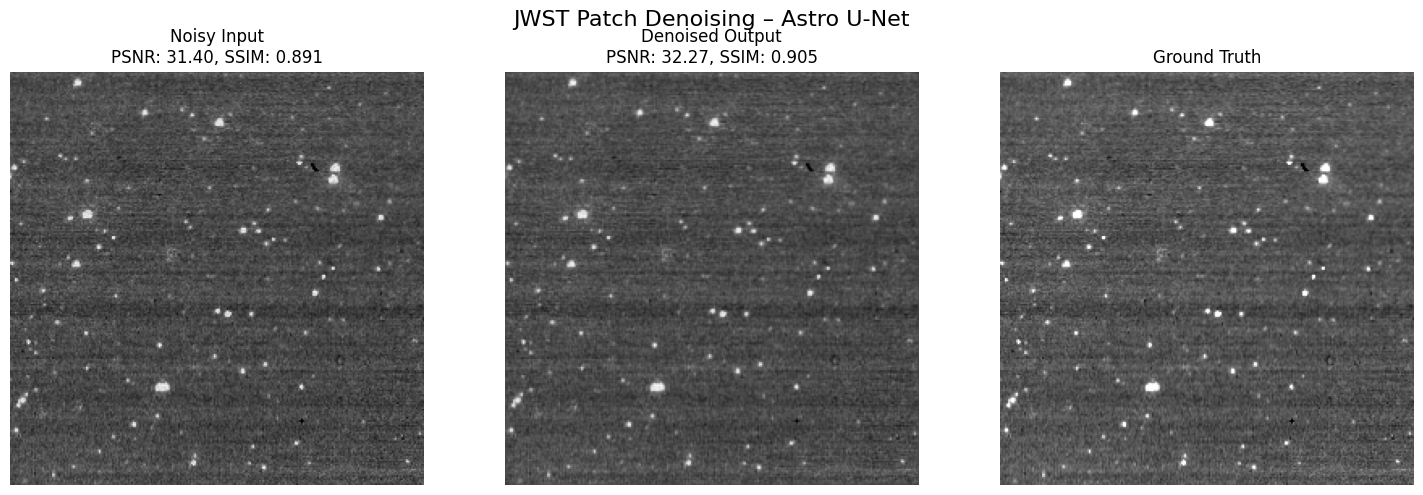

In [50]:
# === Config ===
CHECKPOINT = "checkpoints_astrounet/best_model.pth"
TEST_TXT = "astronet_training/test.txt"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EXP_RATIO = torch.tensor(0.5).to(DEVICE)  # Exposure ratio injected into model
SAVE_DIR = "inference_single/"
os.makedirs(SAVE_DIR, exist_ok=True)

test_set = JWSTAstroDataset(txt_file="./astronet_training/test.txt")

noisy_tensor, clean_tensor = test_set[1]  # or pick another index

noisy_tensor = noisy_tensor.unsqueeze(0).to(DEVICE)  # add batch dim
clean_tensor = clean_tensor.unsqueeze(0).to(DEVICE)

# === Inference ===
with torch.no_grad():
    output_tensor = model(noisy_tensor, exp_time=EXP_RATIO)

# === Convert to numpy ===
noisy_np = noisy_tensor.squeeze().cpu().numpy()
output_np = output_tensor.squeeze().cpu().numpy()
clean_np = clean_tensor.squeeze().cpu().numpy()

show_denoising_result_with_metrics(noisy_np, output_np, clean_np)


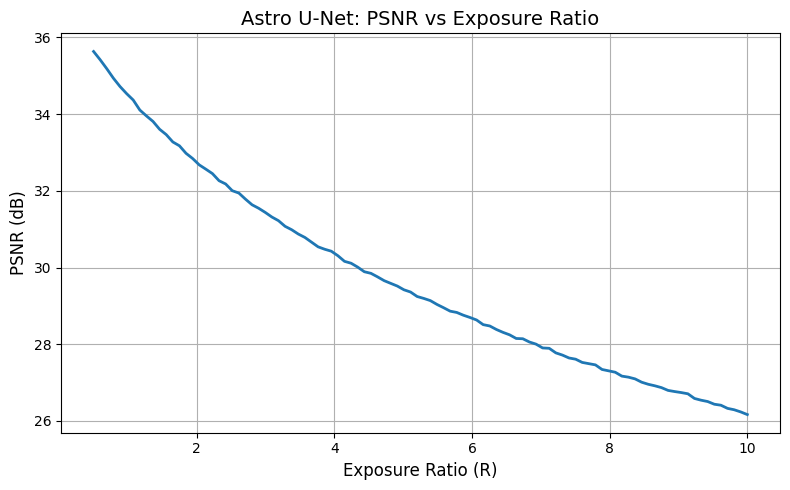

In [48]:
EXP_TIME = 1000.0  # Total exposure time (same across all tests)

# === Load clean patch ===
dataset = JWSTAstroDataset("astronet_training/test.txt")
clean_tensor = dataset[0][1].unsqueeze(0).to(DEVICE)  # Shape: [1, 1, H, W]
clean_np = clean_tensor.squeeze().cpu().numpy()

# # === Noise simulation function ===
# def simulate_poisson_noise(image_np, exp_time, ratio, ron=3, dark=7):
#     img_e = image_np * exp_time
#     signal = np.random.poisson(img_e / ratio)
#     read_noise = np.random.normal(0, ron, image_np.shape)
#     dark_noise = np.random.normal(0, np.sqrt(dark * exp_time / (3600 * ratio)), image_np.shape)
#     noisy_e = signal + read_noise + dark_noise
#     noisy_image = np.clip(noisy_e / (exp_time / ratio), 0, 1)
#     return noisy_image.astype(np.float32)

# === Sweep over exposure ratios ===
ratios = np.linspace(0.5, 10.0, 100)  # 100 finely spaced values
psnr_values = []

for r in ratios:
    noisy_np = simulate_noise(clean_np, EXP_TIME, r)
    noisy_tensor = torch.from_numpy(noisy_np).unsqueeze(0).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output_tensor = model(noisy_tensor, exp_time=torch.tensor(r).to(DEVICE))
    output_np = output_tensor.squeeze().cpu().numpy()

    psnr_val = psnr(clean_np, output_np, data_range=1.0)
    psnr_values.append(psnr_val)

# === Plot ===
plt.figure(figsize=(8, 5))
plt.plot(ratios, psnr_values, label="Denoised PSNR", linewidth=2)
plt.xlabel("Exposure Ratio (R)", fontsize=12)
plt.ylabel("PSNR (dB)", fontsize=12)
plt.title("Astro U-Net: PSNR vs Exposure Ratio", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

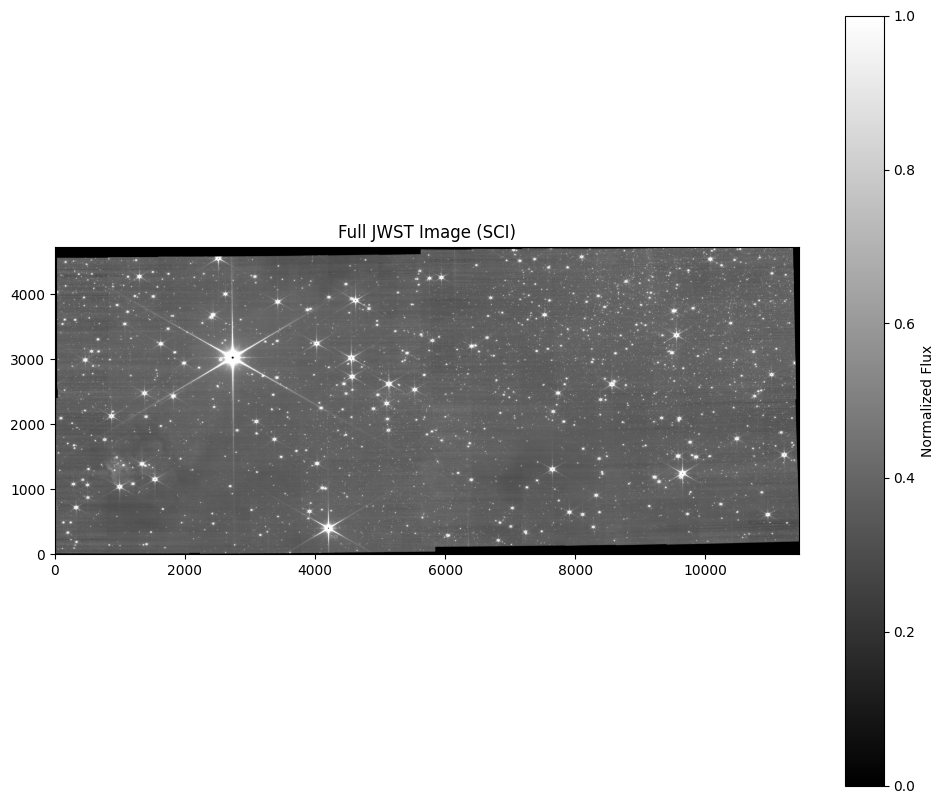

In [14]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

# Load full JWST FITS
path = "jw04147-o012_t001_nircam_clear-f115w_i2d.fits"

with fits.open(path) as hdul:
    image = hdul['SCI'].data
    image = np.nan_to_num(image)

    # Normalize for display
    vmin, vmax = np.percentile(image, [1, 99])
    norm_img = np.clip((image - vmin) / (vmax - vmin), 0, 1)

# Show
plt.figure(figsize=(12, 10))
plt.imshow(norm_img, cmap='gray', origin='lower')
plt.colorbar(label='Normalized Flux')
plt.title("Full JWST Image (SCI)")
plt.show()


In [16]:
# Reconstruction of whole image
def extract_image_patches(image, patch_size=256, stride=128):
    H, W = image.shape
    patches = []
    positions = []
    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            patch = image[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
            positions.append((i, j))
    return patches, positions

def reconstruct_image(patches, positions, image_shape, patch_size=256):
    reconstructed = np.zeros(image_shape)
    weight = np.zeros(image_shape)

    for patch, (i, j) in zip(patches, positions):
        reconstructed[i:i+patch_size, j:j+patch_size] += patch
        weight[i:i+patch_size, j:j+patch_size] += 1

    return reconstructed / np.maximum(weight, 1e-8)

In [17]:
import torch

def denoise_full_image(image, model, exp_ratio=2.0, patch_size=256, stride=128):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    norm_image = np.clip(image / np.percentile(image, 99), 0, 1).astype(np.float32)
    patches, positions = extract_image_patches(norm_image, patch_size, stride)
    denoised_patches = []

    for patch in patches:
        tensor = torch.from_numpy(patch).unsqueeze(0).unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(tensor, exp_time=torch.tensor(exp_ratio).to(device))
        denoised_patches.append(out.squeeze().cpu().numpy())

    denoised_full = reconstruct_image(denoised_patches, positions, image.shape, patch_size)
    return denoised_full


In [33]:
# === Step 1: Create the model instance
model = AstroUNet(exp_injection=True)  # or False if you trained without exposure injection

# === Step 2: Load state_dict
checkpoint_path = "checkpoints_astrounet/best_model.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location="cpu"))  # or "cuda"

# === Step 3: Set to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()


denoised = denoise_full_image(image, model, exp_ratio=0.5)

plt.figure(figsize=(12, 10))
plt.imshow(denoised, cmap='gray', origin='lower')
plt.title("Full JWST Image (Denoised by Astro U-Net)")
plt.colorbar(label='Normalized Flux')
plt.savefig('denoised_full_sag_c.png')
plt.show()





RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [32]:
psnr(denoised, norm_img, data_range=1.0)

np.float64(27.33623647241795)

In [19]:
# Step 3: Save as FITS
fits.writeto("jwst_denoised_full.fits", denoised, overwrite=True)


In [22]:
from jdaviz import Imviz

# Start the viewer
imviz = Imviz()
imviz.app

# Load the FITS image you just saved
imviz.load_data("jwst_denoised_full.fits", data_label="Denoised")
imviz.show()

Application(config='imviz', docs_link='https://jdaviz.readthedocs.io/en/v4.2.1/imviz/index.html', events=['cal…